# Setting up the environment

First, we set up our environment. We use an already compiled and packaged installation of OpenMM and the DLExt plugin.
We copy it from Google Drive and install PySAGES for it.

In [ ]:
%%bash

BASE_URL="https://drive.google.com/u/0/uc?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7&export=download"
wget -q --load-cookies /tmp/cookies.txt "$BASE_URL&confirm=$(wget -q --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')" -O pysages-env.zip
rm -rf /tmp/cookies.txt

In [ ]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [ ]:
%%bash

mkdir -p $PYSAGES_ENV .
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [ ]:
!update-alternatives --auto libcudnn &> /dev/null

In [ ]:
import os
import sys

ver = sys.version_info
sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"
os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:" + os.environ["LD_LIBRARY_PATH"]

## PySAGES

The next step is to install PySAGES.
First, we install the jaxlib version that matches the CUDA installation of this Colab setup. See the JAX documentation [here](https://github.com/google/jax) for more details.

In [ ]:
%%bash

pip install -q --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.0.5.
pip install -q --upgrade "jax[cuda11_cudnn805]" -f https://storage.googleapis.com/jax-releases/jax_releases.html &> /dev/null

Now we can finally install PySAGES. We clone the newest version from [here](https://github.com/SSAGESLabs/PySAGES) and build the remaining pure python dependencies and PySAGES itself.

In [ ]:
%%bash

rm -rf PySAGES
git clone https://github.com/SSAGESLabs/PySAGES.git &> /dev/null
cd PySAGES
pip install -q . &> /dev/null

# Metadynamics-biased simulations

Metadynamics gradually builds a biasing potential from a sum of gaussians that are deposited one at a time every certain number of (user defined) time steps.
There are two flavors of the algorithm, _Standard Metadynamics_ in which the heights of the gaussians is time independent, and _Well-tempered Metadynamics_ for which the heights of the deposited gaussians decreases depending on how frequently are visited the explored regions of collective variable space.

For this Colab, we are using alanine peptide in vacuum as example system.

In [ ]:
%%bash

# Download pdb file with the initial configuration of our system
PDB_URL="https://raw.githubusercontent.com/SSAGESLabs/PySAGES/main/examples/inputs/alanine-dipeptide/adp-vacuum.pdb"
wget -q $PDB_URL

In [ ]:
import numpy

from pysages.utils import try_import

openmm = try_import("openmm", "simtk.openmm")
unit = try_import("openmm.unit", "simtk.unit")
app = try_import("openmm.app", "simtk.openmm.app")


pi = numpy.pi

T = 298.15 * unit.kelvin
dt = 2.0 * unit.femtoseconds
adp_pdb = "adp-vacuum.pdb"


def generate_simulation(pdb_filename=adp_pdb, T=T, dt=dt):
    pdb = app.PDBFile(pdb_filename)

    ff = app.ForceField("amber99sb.xml")
    cutoff_distance = 1.0 * unit.nanometer
    topology = pdb.topology

    system = ff.createSystem(
        topology, constraints=app.HBonds, nonbondedMethod=app.PME, nonbondedCutoff=cutoff_distance
    )

    # Set dispersion correction use.
    forces = {}
    for i in range(system.getNumForces()):
        force = system.getForce(i)
        forces[force.__class__.__name__] = force

    forces["NonbondedForce"].setUseDispersionCorrection(True)
    forces["NonbondedForce"].setEwaldErrorTolerance(1.0e-5)

    positions = pdb.getPositions(asNumpy=True)

    integrator = openmm.LangevinIntegrator(T, 1 / unit.picosecond, dt)
    integrator.setRandomNumberSeed(42)

    simulation = app.Simulation(topology, system, integrator)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()

    return simulation

Next, we load PySAGES and the relevant classes and methods for our problem

In [ ]:
from pysages.grids import Grid
from pysages.colvars import DihedralAngle
from pysages.methods import Metadynamics

import pysages

The next step is to define the collective variable (CV). In this case, we choose the so called $\phi$ and $\psi$ dihedral angles of alanine dipeptide.

For this example we will use the well-tempered version without grids. But these options can be configured.

We set the initial height, standard deviation and deposition frequency `stride` for the gaussians, as well as the $\Delta T$ Metadynamics parameter. And the number of time steps to run the simulation (here we use $9\times10^6$ or 18 ns for the timestep chosen).

We also define a grid, which can be used as optional parameter to accelerate Metadynamics by approximating the biasing potential and its gradient by the closest value at the centers of the grid cells.

_Note:_ when setting $\Delta T$ we need to also provide a value for $k_B$ that matches the internal units used by the backend.

In [ ]:
cvs = [DihedralAngle([4, 6, 8, 14]), DihedralAngle([6, 8, 14, 16])]

well_tempered = True  # False for standard metadynamics
use_grids = False

height = 1.2  # kJ/mol
sigma = [0.35, 0.35]  # radians
deltaT = 5000 if well_tempered else None
stride = 200  # frequency for depositing gaussians
timesteps = int(1e6)
ngauss = timesteps // stride  # total number of gaussians

kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA * unit.kelvin
kB = kB.value_in_unit(unit.kilojoules_per_mole)  # unitless kB value

# Grid for partitioning the bias potential and its gradient
grid = pysages.Grid(lower=(-pi, -pi), upper=(pi, pi), shape=(64, 64), periodic=True)
grid = grid if use_grids else None

method = Metadynamics(cvs, height, sigma, stride, ngauss, deltaT=deltaT, kB=kB, grid=grid)

We now simulate the number of time steps set above.
Make sure to run with GPU support, otherwise, it can take a very long time.
On the GPU this should run in around half an hour.

In [ ]:
state = pysages.run(method, generate_simulation, timesteps)

## Analysis

Let's plot the negative of the sum of gaussians accumulated. This will get close to the free energy surface for long enough simulations (larger than what is practical to run on Colab, but we should get close enough for illustration purposes here).

In [ ]:
from jax import  jit, numpy as np, vmap

from pysages.approxfun import compute_mesh
from pysages.colvars import get_periods
from pysages.methods.metad import sum_of_gaussians

import matplotlib.pyplot as plt

We are now going to gather the information for the heights, standard deviations and centers of the accumulated gaussians and build a function to evaluate their sum at any point of the collective variable space.

In [ ]:
P = get_periods(cvs)
heights = state.heights
centers = state.centers
sigmas = state.sigmas

@jit
def metapotential(xs):
    f = vmap(lambda x: sum_of_gaussians(x, heights, centers, sigmas, P))
    return f(xs)

Next we use the biasing potential to estimate the free energy surface. For well-tempered metadynamics this is equal to the sum of accumulated gaussians scaled by the factor $-(T + \Delta T)\, / \,\Delta T$.

In [ ]:
plot_grid = pysages.Grid(lower=(-pi, -pi), upper=(pi, pi), shape=(64, 64), periodic=True)
xi = (compute_mesh(plot_grid) + 1) / 2 * plot_grid.size + plot_grid.lower

alpha = 1 if method.deltaT is None else (T.value_in_unit(unit.kelvin) + method.deltaT) / method.deltaT
kT = kB * T.value_in_unit(unit.kelvin)

A = metapotential(xi) * -alpha / kT
A = A - A.min()
A = A.reshape(plot_grid.shape)

And plot it.

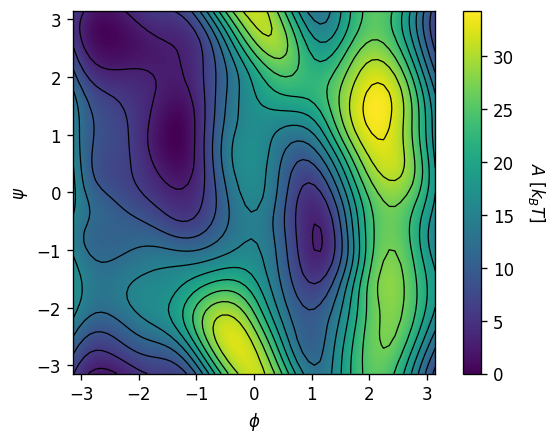

In [ ]:
fig, ax = plt.subplots(dpi=120)

im = ax.imshow(
    A, interpolation="bicubic", origin="lower", extent=[-pi, pi, -pi, pi]
)
ax.contour(
    A, levels=12, linewidths=0.75, colors="k", extent=[-pi, pi, -pi, pi]
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r"$A~[k_{B}T]$", rotation=270, labelpad=20)

plt.show()

Lastly, we plot the height of the gaussians as a function of time and observe that their height decreases at an exponential rate as expected for well-tempered metadynamics.

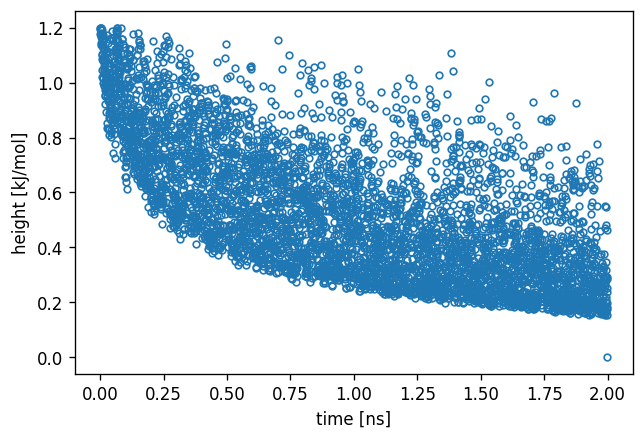

In [ ]:
_dt = method.context[0].sampler.snapshot.dt
ts = _dt * 1e-3 * np.arange(0, heights.size) * method.stride

fig, ax = plt.subplots(dpi=120)
ax.plot(ts, heights, "o", mfc="none", ms=4)
ax.set_xlabel("time [ns]")
ax.set_ylabel("height [kJ/mol]")
plt.show()